执行 Python 程序的解释器，包含一个编译器和一个虚拟机。


- 当我们在命令行敲下python xxxx.py时，编译器首先登场，将源代码编译成PyCodeObject对象,包含字节码、以及执行字节码时所需的名字和常量。
- <font color= red>当编译完成后，虚拟机负责维护执行上下文，逐条执行字节码指令</font>。执行上下文中最核心的名字空间，便是由虚拟机负责维护的。


因此 Python程序的执行原理可以用两个词来概括：虚拟机和字节码。

Python的<font color= red>字节码指令</font>有120多个，但其中有几个太常见了，我们这里必须要提一下，然后再举例说明。
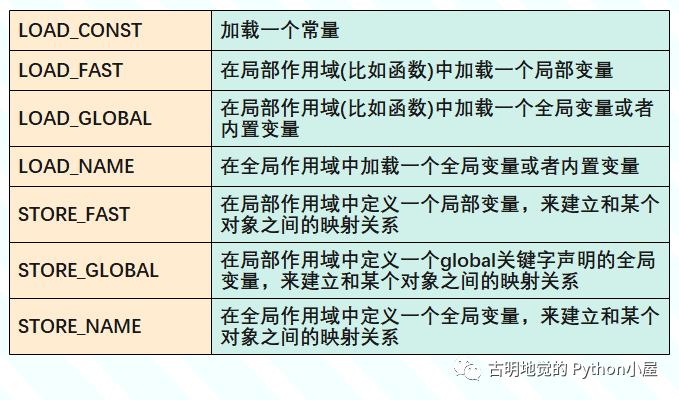


In [1]:
import dis
name = "古明"

def foo():
    gender = "female"
    print(gender)
    print(name)

dis.dis(foo)

  5           0 LOAD_CONST               1 ('female')
              2 STORE_FAST               0 (gender)

  6           4 LOAD_GLOBAL              0 (print)
              6 LOAD_FAST                0 (gender)
              8 CALL_FUNCTION            1
             10 POP_TOP

  7          12 LOAD_GLOBAL              0 (print)
             14 LOAD_GLOBAL              1 (name)
             16 CALL_FUNCTION            1
             18 POP_TOP
             20 LOAD_CONST               0 (None)
             22 RETURN_VALUE


## 流程控制
前面我们介绍了虚拟机中常见的字节码指令，并且整个过程中，所有的指令都是从上往下顺序执行的，不涉及任何的跳转。但显然这是不够的，因为怎么能没有流程控制呢，像 <font color= red>if、for、while等等，都属于流程控制</font>。


### if语句
整个 if 语句的字节码指令还是很简单的。就是从上到下依次判断每一个分支，如果某个分支条件成立，就执行该分支的代码，执行完毕后结束整个 if 语句；分支不成立，那么就跳转到下一个分支。

核心指令就在于COMPARE_OP、POP_JUMP_IF_FALSE和JUMP_FORWARD，其作用如下：

- <font color= red>COMPARE_OP</font>：进行比较操作；

- <font color= red>POP_JUMP_IF_FALSE</font>：表示当比较结果为假时，跳到下一个分支，否则执行此分支的代码；

- <font color= red>JUMP_FORWARD</font>：从当前位置跳转指定的偏移量；

字节码偏移量之前有几个>>这样的符号，是if语句中的每一个分支开始的地方，当然最后的>>是返回值

In [2]:
s = '''
score = 90

if score >= 85:
    print("Good")

elif score >= 60:
    print("Normal")

else:
    print("Bad")
'''
import dis
dis.dis(compile(s,"<file>",'exec'))

  2           0 LOAD_CONST               0 (90)
              2 STORE_NAME               0 (score)

  4           4 LOAD_NAME                0 (score)
              6 LOAD_CONST               1 (85)
              8 COMPARE_OP               5 (>=)
             10 POP_JUMP_IF_FALSE       22

  5          12 LOAD_NAME                1 (print)
             14 LOAD_CONST               2 ('Good')
             16 CALL_FUNCTION            1
             18 POP_TOP
             20 JUMP_FORWARD            26 (to 48)

  7     >>   22 LOAD_NAME                0 (score)
             24 LOAD_CONST               3 (60)
             26 COMPARE_OP               5 (>=)
             28 POP_JUMP_IF_FALSE       40

  8          30 LOAD_NAME                1 (print)
             32 LOAD_CONST               4 ('Normal')
             34 CALL_FUNCTION            1
             36 POP_TOP
             38 JUMP_FORWARD             8 (to 48)

 11     >>   40 LOAD_NAME                1 (print)
             42 LOAD_

### for、while 循环语句
在介绍 if 语句的时候，我们已经见识了最基本的控制，但是我们发现 if 只能向前跳转，不管是哪个分支，都是通过 JUMP_FORWARD。而下面介绍的 for、while 循环，指令是可以回退的，也就是向后跳转。

In [3]:
s = '''
lst = [1,2]
for item in lst:
    print(item)
'''

dis.dis(compile(s,'<for>','exec'))

  2           0 LOAD_CONST               0 (1)
              2 LOAD_CONST               1 (2)
              4 BUILD_LIST               2
              6 STORE_NAME               0 (lst)

  3           8 LOAD_NAME                0 (lst)
             10 GET_ITER
        >>   12 FOR_ITER                12 (to 26)
             14 STORE_NAME               1 (item)

  4          16 LOAD_NAME                2 (print)
             18 LOAD_NAME                1 (item)
             20 CALL_FUNCTION            1
             22 POP_TOP
             24 JUMP_ABSOLUTE           12
        >>   26 LOAD_CONST               2 (None)
             28 RETURN_VALUE


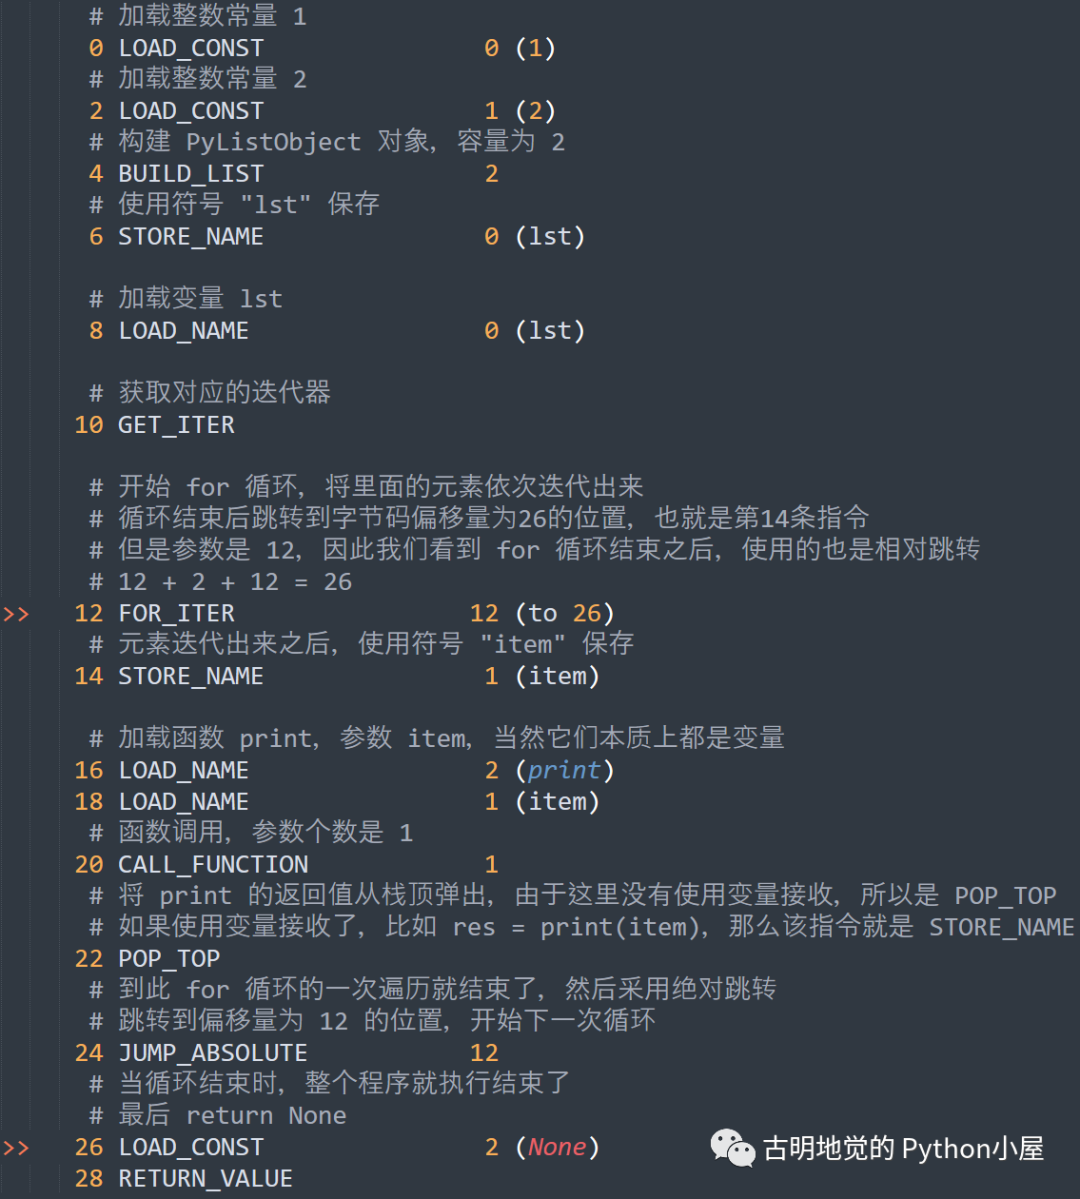

- 我们直接从 10 GET_ITER 开始看起，首先 for 循环遍历一个对象的时候，要满足后面的<font color= red>对象是一个可迭代对象</font>，然后会<font color= red>先调用这个对象的__iter__方法，把它变成一个迭代器。再不断地调用这个迭代器的__next__方法，一步一步将里面的值全部迭代出来</font>。


- 另外，我们说 Python 里面是先有值，后有变量，for 循环也不例外。<font color= red>循环的时候，先将 lst 对应的迭代器中的元素迭代出来，然后再让变量 item 指向</font>。所以字节码中先是 12 FOR_ITER，然后才是 14 STORE_NAME。


- 因此包含10个元素的迭代器，需要迭代11次才能结束。因为 for 循环事先是不知道迭代10次就能结束的，它需要再迭代一次<font color= red>发现没有元素可以迭代、从而抛出StopIteration异常、再进行捕捉，之后才能结束</font>。


- 和 if 不一样，<font color= red>for循环使用的是绝对跳转,JUMP_ABSOLUTE </font>。强制设置 next_instr 的值，将 next_instr 设定到距离f->f_code->co_code开始地址的某一特定偏移量的位置。这个偏移量由JUMP_ABSOLUTE的指令参数决定，所以该参数就成了 for循环中指令回退动作的最关键的一点。

### While循环语句

In [2]:
a = 0
while a < 10:
    a += 1
    if a == 5:
        continue
    if a == 7:
        break
    print(a)

1
2
3
4
6


In [5]:
s = '''
a = 0
while a < 10:
    a += 1
    if a == 5:
        continue
    if a == 7:
        break
    print(a)
'''
dis.dis(compile(s,"<while>","exec"))

  2           0 LOAD_CONST               0 (0)
              2 STORE_NAME               0 (a)

  3     >>    4 LOAD_NAME                0 (a)
              6 LOAD_CONST               1 (10)
              8 COMPARE_OP               0 (<)
             10 POP_JUMP_IF_FALSE       50

  4          12 LOAD_NAME                0 (a)
             14 LOAD_CONST               2 (1)
             16 INPLACE_ADD
             18 STORE_NAME               0 (a)

  5          20 LOAD_NAME                0 (a)
             22 LOAD_CONST               3 (5)
             24 COMPARE_OP               2 (==)
             26 POP_JUMP_IF_FALSE       30

  6          28 JUMP_ABSOLUTE            4

  7     >>   30 LOAD_NAME                0 (a)
             32 LOAD_CONST               4 (7)
             34 COMPARE_OP               2 (==)
             36 POP_JUMP_IF_FALSE       40

  8          38 JUMP_ABSOLUTE           50

  9     >>   40 LOAD_NAME                1 (print)
             42 LOAD_NAME             

- <font color= red>break 是跳转到 while循环结束后的第一条指令</font>
- <font color= red>continue 则是跳转到 while 循环的开始位置</font>

<font color= red>break和continue本质上都是一个JUMP_ABSOLUTE，都是通过绝对跳转实现的</font>。



然后执行一圈之后，再通过JUMP_ABSOLUTE跳转回去，显然此时的指令参数和 continue 是一样的，都是 while 循环的开始位置。


当循环条件不满足的时候，指令 POP_JUMP_IF_FALSE 发现结果为 False，直接结束循环，此时的指令参数和 break 是一样的，都是跳转到 while 循环的结束位置，或者说 while 循环的下一条指令的开始位置。

### 小结

本部分介绍了虚拟机执行字节码的基本操作，以及实现 if , for , while 语句中流程控制的方法。

- 基于比较运算，然后跳转：COMPARE_OP，POP_JUMP_IF_FALSE
- 相对跳转：JUMP_FORWARD
- 绝对调转：JUMP_ABSOLUTE（可向前跳转）
- 迭代对象：GET_ITER，FOR_ITER
